# Customer Churn Prediction
---
This notebook walks through building a **customer churn prediction model** step by step:
1. Load and explore the data
2. Look at churn patterns with visualizations
3. Prepare the data for modeling
4. Train and compare models
5. Pick the best model and test it


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# nicer plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Customer Churn Prediction Analysis")

Customer Churn Prediction Analysis


## Step 1: Load and explore the data
We first check the dataset size, columns, missing values, and basic stats.

In [5]:
customer_dataset = pd.read_csv('/content/customer_churn_data.csv')

print(f"Data shape: {customer_dataset.shape}")
print("\nColumn info:")
print(customer_dataset.info())

missing = customer_dataset.isnull().sum()
if missing.sum() == 0:
    print("No missing values found.")
else:
    print("Missing values:")
    print(missing[missing > 0])

print("\nSummary stats:")
print(customer_dataset.describe())

Data shape: (10000, 24)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            10000 non-null  object 
 1   age                    10000 non-null  int64  
 2   gender                 10000 non-null  object 
 3   senior_citizen         10000 non-null  int64  
 4   partner                10000 non-null  object 
 5   dependents             10000 non-null  object 
 6   tenure                 10000 non-null  int64  
 7   phone_service          10000 non-null  object 
 8   multiple_lines         10000 non-null  object 
 9   internet_service       10000 non-null  object 
 10  online_security        10000 non-null  object 
 11  online_backup          10000 non-null  object 
 12  device_protection      10000 non-null  object 
 13  tech_support           10000 non-null  object 
 14  streaming_tv     

## Step 2: Exploratory Data Analysis
We look at churn distribution, demographics, service features, and correlations.

Churn distribution (%):
churn
No     77.28
Yes    22.72
Name: proportion, dtype: float64


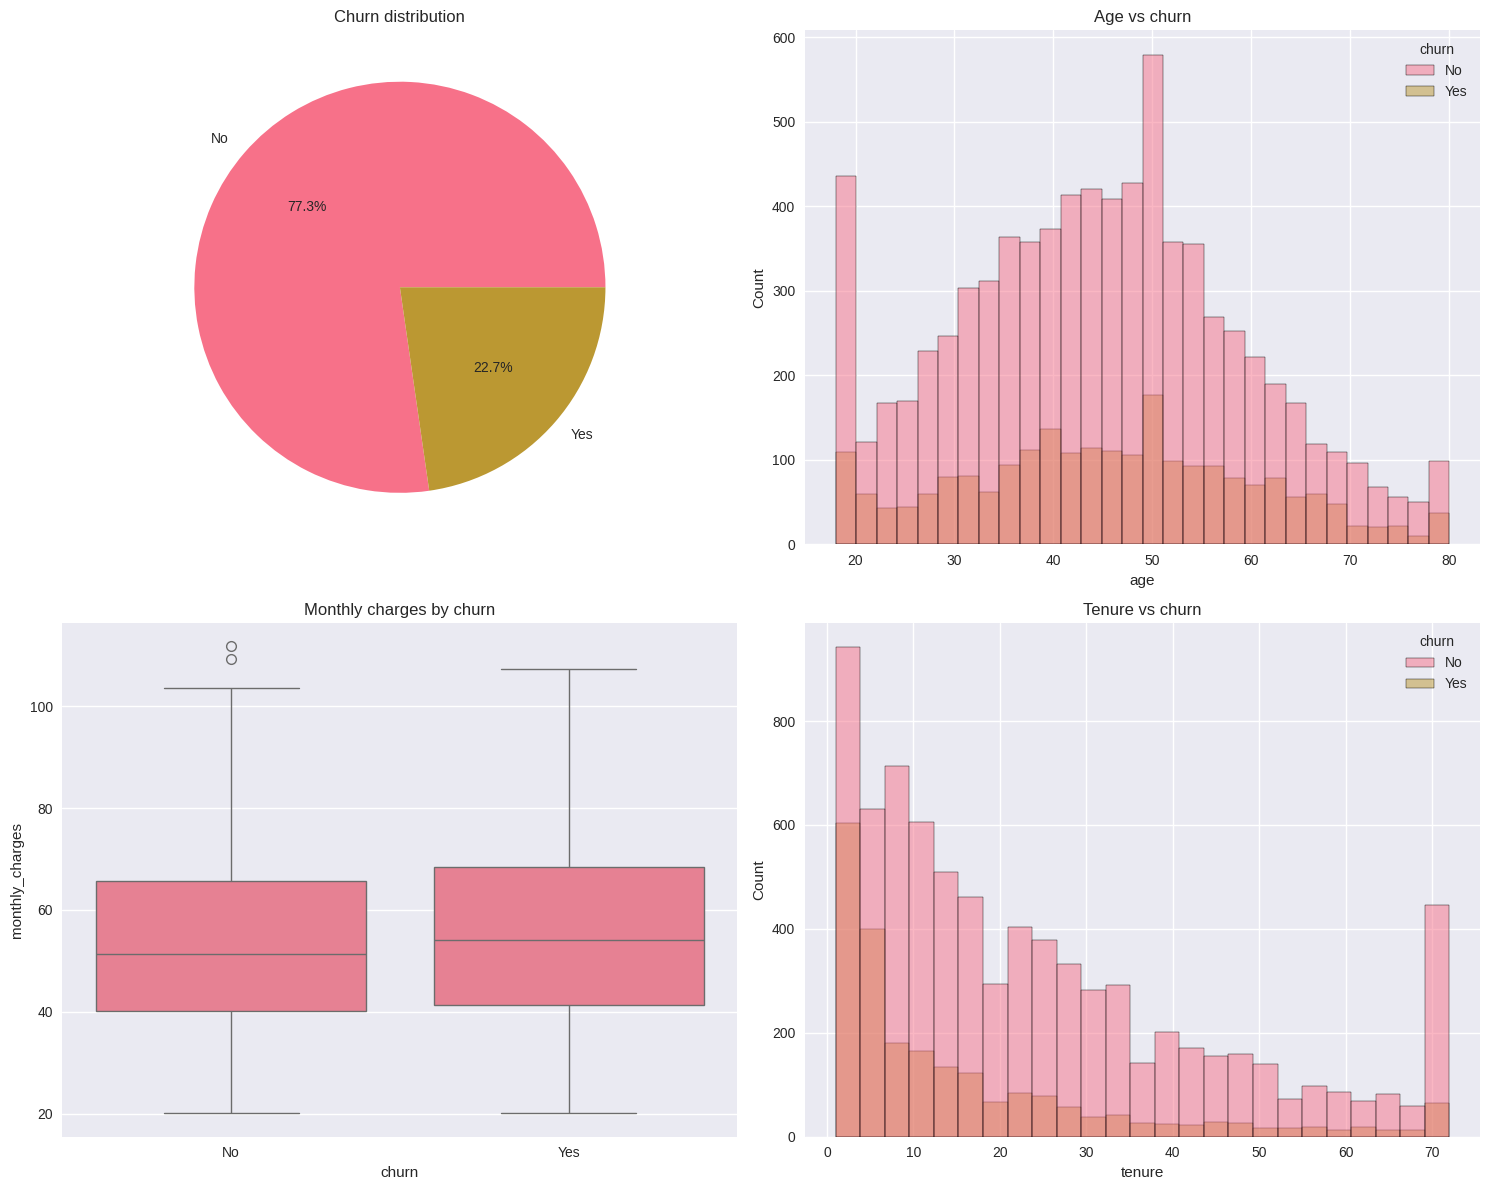

In [6]:
churn_dist = customer_dataset['churn'].value_counts(normalize=True) * 100
print("Churn distribution (%):")
print(churn_dist)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
ax1.pie(customer_dataset['churn'].value_counts(), labels=['No','Yes'], autopct='%1.1f%%')
ax1.set_title('Churn distribution')

sns.histplot(data=customer_dataset, x='age', hue='churn', bins=30, ax=ax2)
ax2.set_title('Age vs churn')

sns.boxplot(data=customer_dataset, x='churn', y='monthly_charges', ax=ax3)
ax3.set_title('Monthly charges by churn')

sns.histplot(data=customer_dataset, x='tenure', hue='churn', bins=25, ax=ax4)
ax4.set_title('Tenure vs churn')

plt.tight_layout()
plt.show()

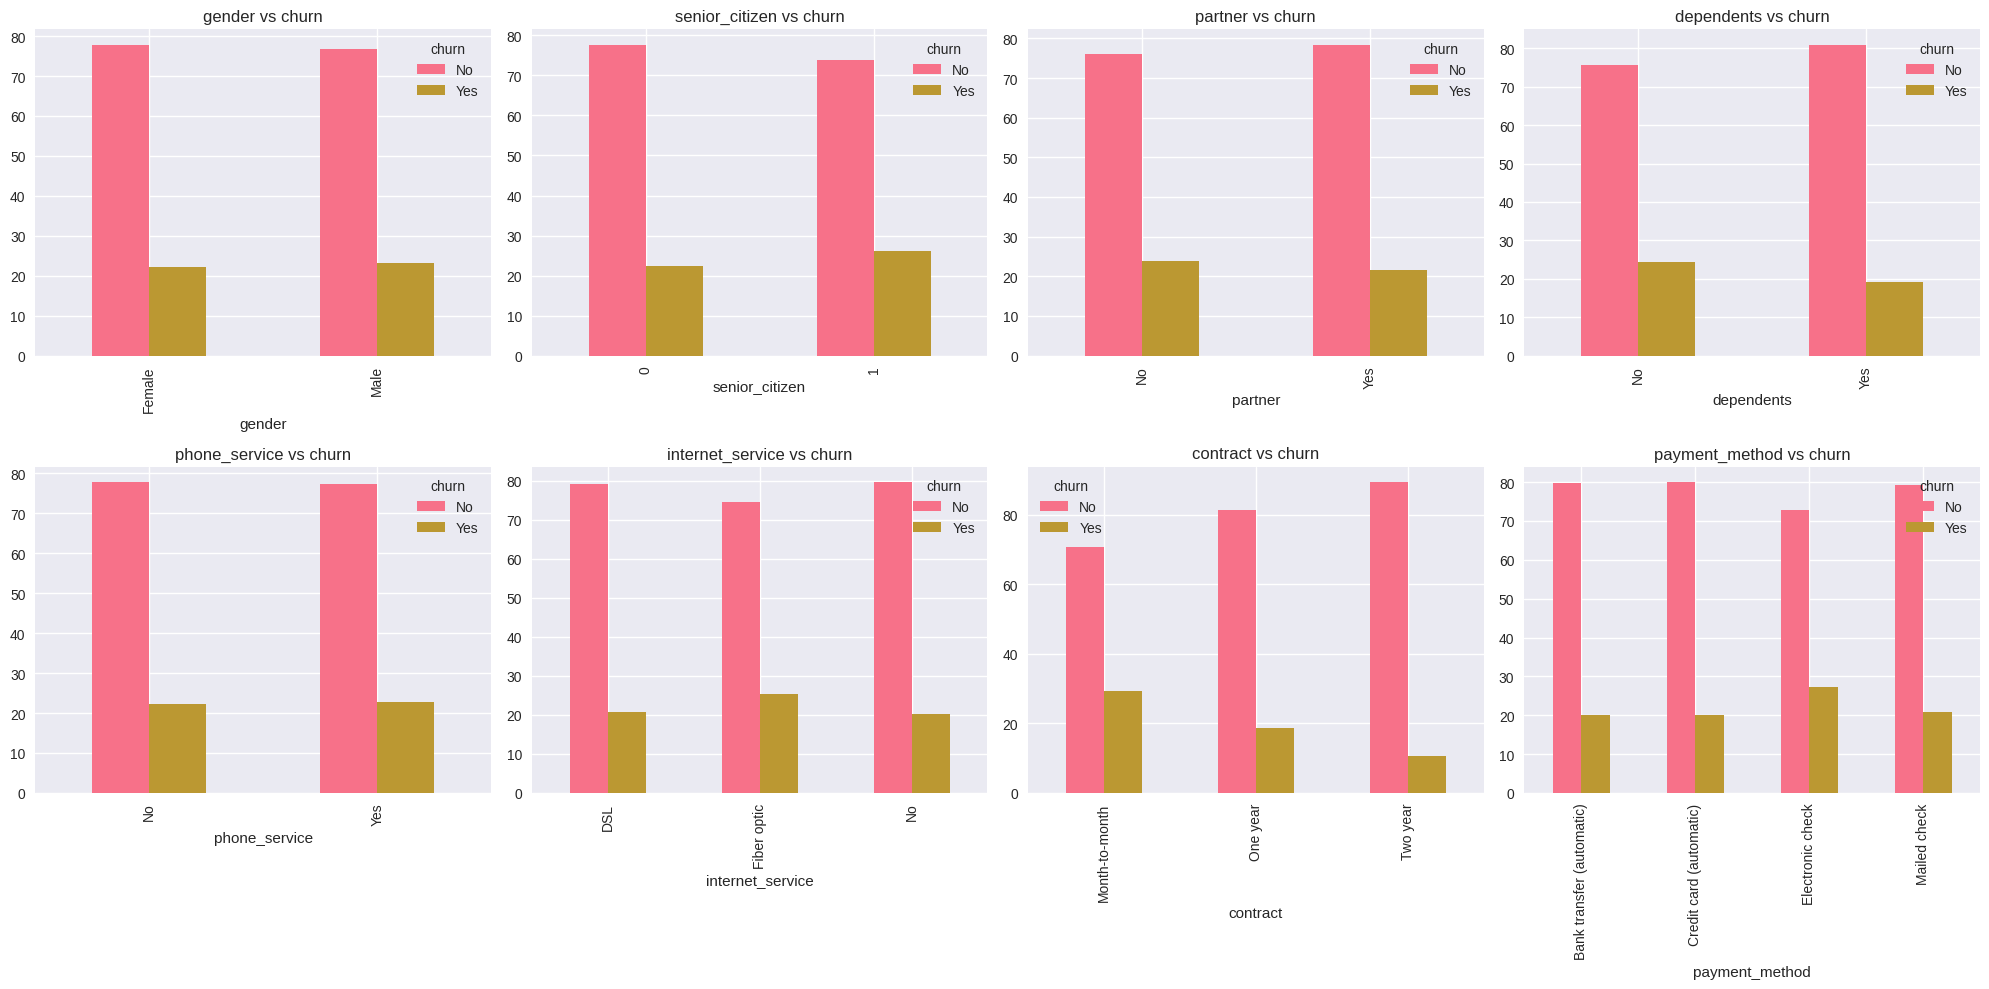

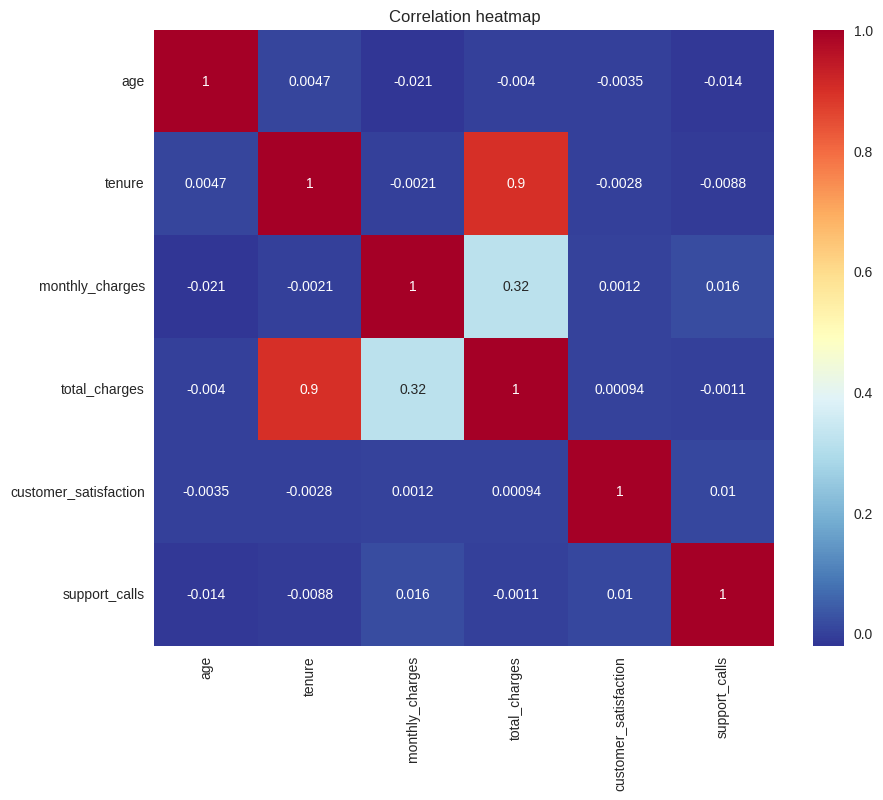

In [7]:
demo_cols = ['gender', 'senior_citizen', 'partner', 'dependents']
service_cols = ['phone_service', 'internet_service', 'contract', 'payment_method']
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(demo_cols + service_cols):
    tab = pd.crosstab(customer_dataset[col], customer_dataset['churn'], normalize='index') * 100
    tab.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col} vs churn')

plt.tight_layout()
plt.show()

num_cols = ['age','tenure','monthly_charges','total_charges','customer_satisfaction','support_calls']
plt.figure(figsize=(10,8))
sns.heatmap(customer_dataset[num_cols].corr(), annot=True, cmap='RdYlBu_r')
plt.title('Correlation heatmap')
plt.show()

## Step 3: Data preprocessing
We encode categorical variables, create a few new features, split data, and scale numeric features.

In [8]:
data = customer_dataset.copy()

binary_cols = ['gender','partner','dependents','phone_service','paperless_billing','churn']
for col in binary_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

cat_cols = ['multiple_lines','internet_service','online_security','online_backup',
           'device_protection','tech_support','streaming_tv','streaming_movies',
           'contract','payment_method']
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

data['charges_per_tenure'] = data['monthly_charges'] / (data['tenure']+1)
data['is_high_spender'] = (data['monthly_charges'] > data['monthly_charges'].median()).astype(int)
data['low_satisfaction'] = (data['customer_satisfaction'] <= 2).astype(int)

X = data.drop(['churn','customer_id'], axis=1)
y = data['churn']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

scaler = StandardScaler()
num_cols = ['age','tenure','monthly_charges','total_charges','customer_satisfaction','support_calls','charges_per_tenure']
for df in [X_train,X_val,X_test]:
    df[num_cols] = scaler.fit_transform(df[num_cols])

print("Train/Val/Test sizes:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test sizes: (6000, 36) (2000, 36) (2000, 36)


## Step 4: Model training
We train a few common classification models with basic hyperparameter tuning.

In [9]:
models = {}
metrics = {}

param_lr = {'C':[0.1,1,10], 'penalty':['l1','l2'], 'solver':['liblinear']}
lr = GridSearchCV(LogisticRegression(random_state=42), param_lr, cv=3, scoring='f1')
lr.fit(X_train, y_train)
models['Logistic Regression'] = lr.best_estimator_

param_dt = {'max_depth':[5,10,15], 'min_samples_split':[10,20], 'min_samples_leaf':[5,10]}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_dt, cv=3, scoring='f1')
dt.fit(X_train, y_train)
models['Decision Tree'] = dt.best_estimator_

param_rf = {'n_estimators':[50,100], 'max_depth':[10,15], 'min_samples_split':[10,20]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=3, scoring='f1')
rf.fit(X_train, y_train)
models['Random Forest'] = rf.best_estimator_

param_svm = {'C':[0.1,1,10], 'kernel':['rbf','linear'], 'gamma':['scale','auto']}
svm = GridSearchCV(SVC(random_state=42), param_svm, cv=3, scoring='f1')
svm.fit(X_train, y_train)
models['SVM'] = svm.best_estimator_

print("Models trained.")

Models trained.


## Step 5: Model evaluation
We compare models using accuracy, precision, recall, and F1-score.

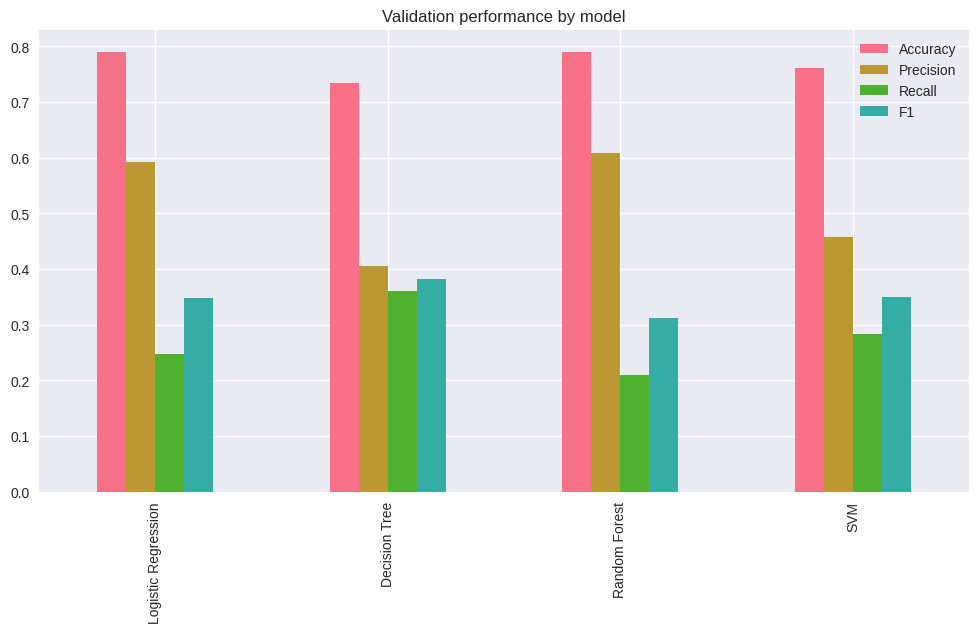

Best model: Decision Tree


In [10]:
for name, model in models.items():
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds)
    rec = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    metrics[name] = {'Accuracy':acc,'Precision':prec,'Recall':rec,'F1':f1}

pd.DataFrame(metrics).T.plot(kind='bar', figsize=(12,6))
plt.title('Validation performance by model')
plt.show()

best_model = max(metrics, key=lambda x: metrics[x]['F1'])
print("Best model:", best_model)

## Step 6: Final test evaluation
We test the chosen model on unseen data and look at confusion matrices.

Test set performance:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1546
           1       0.41      0.32      0.36       454

    accuracy                           0.74      2000
   macro avg       0.61      0.59      0.60      2000
weighted avg       0.72      0.74      0.73      2000



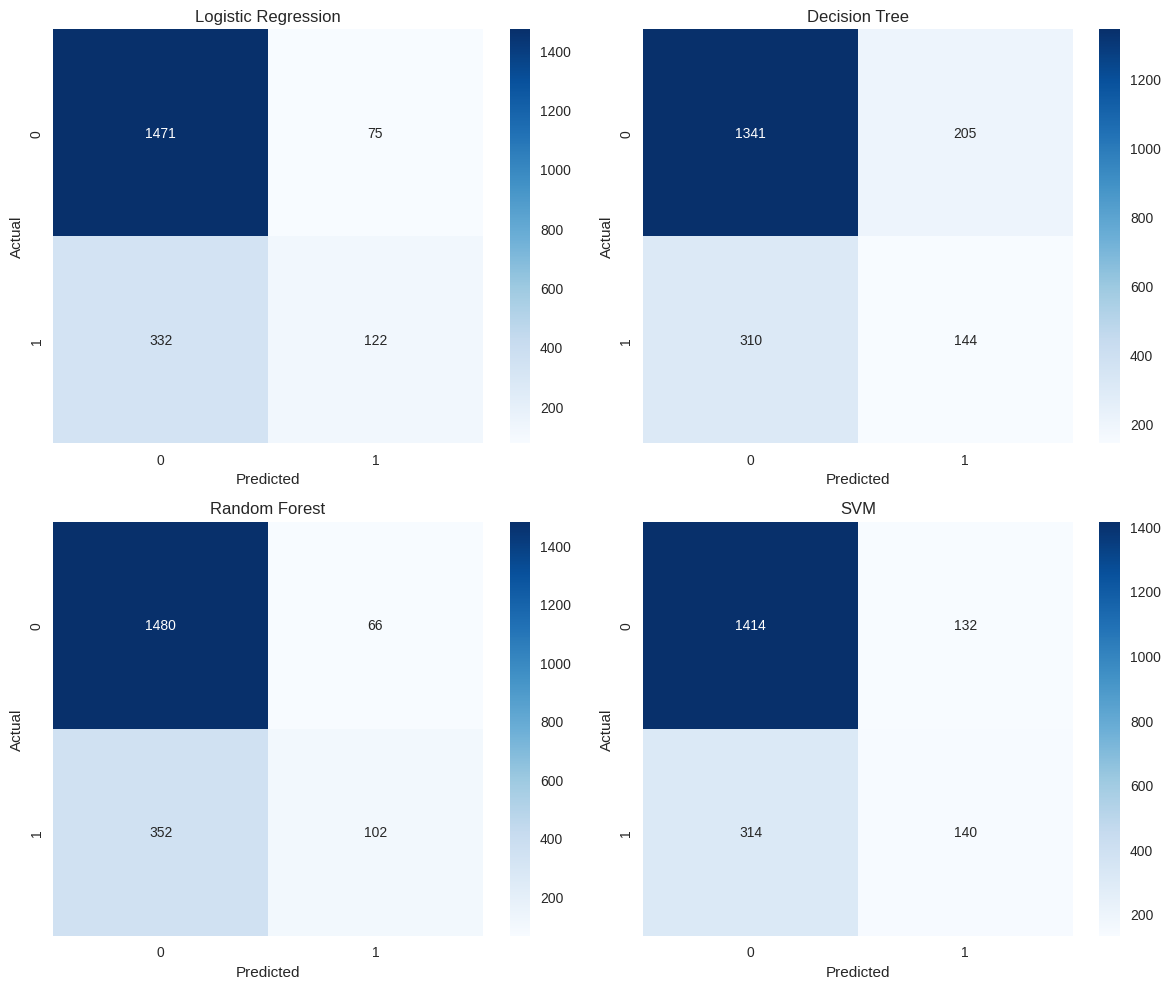

In [11]:
final_preds = models[best_model].predict(X_test)
print("Test set performance:")
print(classification_report(y_test, final_preds))

fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.ravel()
for i,(name, model) in enumerate(models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.show()